# QRAO Max-Cut on an IBM Quantum QPU

This notebook builds a small Max-Cut instance, compresses it with a (3,1,$p$)-QRAC, solves the relaxed Hamiltonian with VQE on a real IBM backend, and uses hardware magic rounding to recover a bitstring for the original problem.

Prerequisites:
- `qiskit-ibm-runtime` is installed.
- Your IBM Quantum account is already saved locally.
- You are comfortable submitting real jobs to a QPU.


If you have not saved your IBM Quantum credentials yet, uncomment and run the next cell once, then comment it back out.

In [ ]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# QiskitRuntimeService.save_account(
#     token="YOUR_IBM_QUANTUM_TOKEN",
#     set_as_default=True,
#     overwrite=True,
# )


In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import (
    EstimatorV2 as Estimator,
    QiskitRuntimeService,
    SamplerV2 as Sampler,
)

from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.algorithms.qrao import (
    MagicRounding,
    QuantumRandomAccessEncoding,
    QuantumRandomAccessOptimizer,
)
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_optimization.optimizers import COBYLA


Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_5 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 - 2*x_4*x_5 + 2*x_0
  + 2*x_1 + 2*x_2 + 2*x_3 + 2*x_4 + 2*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



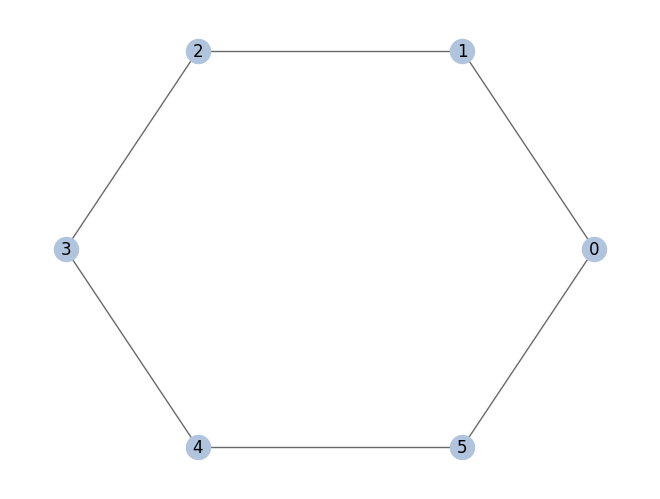

In [2]:
# A 6-cycle is simple, deterministic, and still compresses from 6 variables to 2 qubits.
graph = nx.cycle_graph(6)
layout = nx.circular_layout(graph)

maxcut = Maxcut(graph)
problem = maxcut.to_quadratic_program()

print(problem.prettyprint())

nx.draw(
    graph,
    pos=layout,
    with_labels=True,
    node_color="lightsteelblue",
    edge_color="dimgray",
)
plt.show()


In [3]:
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
encoding.encode(problem)

print(f"Original binary variables: {encoding.num_vars}")
print(f"Qubits after QRAO encoding: {encoding.num_qubits}")
print(f"Compression ratio: {encoding.compression_ratio:.2f}")
print(f"Minimum recovery probability: {encoding.minimum_recovery_probability:.3f}")
print(f"Encoded qubit operator:\n{encoding.qubit_op}")


Original binary variables: 6
Qubits after QRAO encoding: 2
Compression ratio: 3.00
Minimum recovery probability: 0.789
Encoded qubit operator:
SparsePauliOp(['XX', 'XZ', 'YX', 'YY', 'ZY', 'ZZ'],
              coeffs=[1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j])


In [4]:
service = QiskitRuntimeService()

# Set this to a concrete device name such as "ibm_brisbane" to pin the run.
backend_name = None

if backend_name:
    backend = service.backend(backend_name)
else:
    backend = service.least_busy(
        operational=True,
        simulator=False,
        min_num_qubits=encoding.num_qubits,
    )

print(f"Using backend: {backend.name}")

pass_manager = generate_preset_pass_manager(
    backend=backend,
    optimization_level=1,
)


Using backend: ibm_fez


In [5]:
# The open plan does not allow sessions, so use job mode.
# This is slower for VQE because each primitive call is an independent job.
estimator = Estimator(mode=backend)
sampler = Sampler(mode=backend)

shots = 2048

sampler.options.default_shots = shots
# Compatibility shim for qiskit-optimization 0.8.0 MagicRounding,
# which reads `sampler.default_shots` directly for V2 samplers.
sampler.default_shots = shots
estimator.options.default_shots = shots
estimator.options.default_precision = 0.05
estimator.options.resilience_level = 1
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"
estimator.options.dynamical_decoupling.enable = True
estimator.options.dynamical_decoupling.sequence_type = "XY4"
estimator.options.twirling.enable_gates = True
estimator.options.twirling.num_randomizations = "auto"

# Keep the demo intentionally small to limit QPU time.
ansatz = RealAmplitudes(encoding.num_qubits, reps=1, entanglement="full")
initial_point = np.zeros(ansatz.num_parameters)

vqe = VQE(
    estimator=estimator,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=15),
    initial_point=initial_point,
    pass_manager=pass_manager,
)

magic_rounding = MagicRounding(
    sampler=sampler,
    basis_sampling="uniform",
    seed=7,
    pass_manager=pass_manager,
)

qrao = QuantumRandomAccessOptimizer(
    min_eigen_solver=vqe,
    rounding_scheme=magic_rounding,
)


/var/folders/tm/6bh1bn3x6pgfgp8nvpknylq40000gn/T/ipykernel_33364/1080528528.py:25: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(encoding.num_qubits, reps=1, entanglement="full")


The next cell submits real jobs to the selected backend. Expect queue time and billable usage.

In [6]:
print("Submitting QRAO jobs to the QPU...")
result = qrao.solve(problem)
print("Hardware run complete.")


Submitting QRAO jobs to the QPU...


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [ ]:
best_x = np.asarray(result.x, dtype=int).tolist()
sorted_samples = sorted(result.samples, key=lambda sample: sample.fval, reverse=True)

print(f"QRAO objective value: {result.fval}")
print(f"Best bitstring: {best_x}")
print(f"Relaxed objective value: {-result.relaxed_fval}")
print(f"Distinct rounded samples: {len(result.samples)}")
print("Top 5 rounded samples:")
for sample in sorted_samples[:5]:
    print(sample)


In [ ]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
exact_result = exact.solve(problem)

print(f"Exact objective value: {exact_result.fval}")
print(f"Approximation ratio: {result.fval / exact_result.fval:.3f}")


In [ ]:
partition = maxcut.interpret(result)
print(f"Recovered partition: {partition}")

colors = ["tab:blue" if node in partition[0] else "tab:orange" for node in graph.nodes()]

nx.draw(
    graph,
    pos=layout,
    with_labels=True,
    node_color=colors,
    edge_color="dimgray",
)
plt.show()
